In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
df=pd.read_csv('star_classification.csv')
#feature selection
df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID','plate','MJD','fiber_ID'], axis='columns')

#cleaning the data
df = df[(df['u'] >= 0)]

print(df.describe())

                  u             g             r             i             z  \
count  99999.000000  99999.000000  99999.000000  99999.000000  99999.000000   
mean      22.080679     20.631583     19.645777     19.084865     18.768988   
std        2.251068      2.037384      1.854763      1.757900      1.765982   
min       10.996230     10.498200      9.822070      9.469903      9.612333   
25%       20.352410     18.965240     18.135795     17.732280     17.460830   
50%       22.179140     21.099930     20.125310     19.405150     19.004600   
75%       23.687480     22.123775     21.044790     20.396510     19.921120   
max       32.781390     31.602240     29.571860     32.141470     29.383740   

           redshift  
count  99999.000000  
mean       0.576667  
std        0.730709  
min       -0.009971  
25%        0.054522  
50%        0.424176  
75%        0.704172  
max        7.011245  


In [3]:
#turning the Class values into categorical data
df=df.rename(columns = {'class':'Class'})
df.Class = df.Class.astype('category')
cat_columns = df.select_dtypes(['category']).columns
cat_columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [4]:
def mase_seasonal(y_true, y_pred, seasonality = 4):
    #absolute errors
    mae_abs = np.mean(np.abs(y_true - y_pred))

    #absolute errors with seasonal naivety
    mae_seasonal_naive = np.mean(np.abs(y_true[seasonality:] - y_true[:-seasonality]))

    # Avoid division by zero
    if mae_seasonal_naive == 0:
        return np.nan 

    return mae_abs / mae_seasonal_naive

In [12]:
# drop redshift and class for classification
df_no_red = df.drop('redshift',axis='columns')
X = df_no_red.drop('Class',axis='columns')
y = np.array(df['redshift'])
red_actual = np.array(df['Class'])

In [5]:
# regression over whole dataset only keeping high certainty predictions
df_no_class = df.drop('Class',axis='columns')
X3 = df_no_class.drop(columns=['redshift'])
y3 = df_no_class['redshift'].values

X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,test_size=0.2, random_state = 42)

#array dimensions
y3_train = y3_train.transpose()
y3_test = y3_test.transpose()
X3_test_array = X3_test.values

rf3_model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=False)  

# Train the model on the training set
rf3_model.fit(X3_train, y3_train)

# Make predictions on the test set for each tree
predictions_per_tree = np.stack([tree.predict(X3_test) for tree in rf3_model.estimators_])

# Compute mean prediction and standard deviation (uncertainty)
y_pred_mean = predictions_per_tree.mean(axis=0)
y_pred_std = predictions_per_tree.std(axis=0)

# Evaluate performance
mse0 = mean_squared_error(y3_test, y_pred_mean)
mase_value = mase_seasonal(y3_test, y_pred_mean)

print("MSE:", mse0)
print(f"RMSE:", np.sqrt(mse0))
print(f"MAE:", mean_absolute_error(y3_test, y_pred_mean))
print("MASE (Seasonal):", mase_value)
print(f"R2:", r2_score(y3_test, y_pred_mean))

/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWa

/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWa

MSE: 0.3033313994291589
RMSE: 0.550755299047734
MAE: 0.250110468845436
MASE (Seasonal): 0.36570523568012275
R2: 0.4328236481115


/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWa

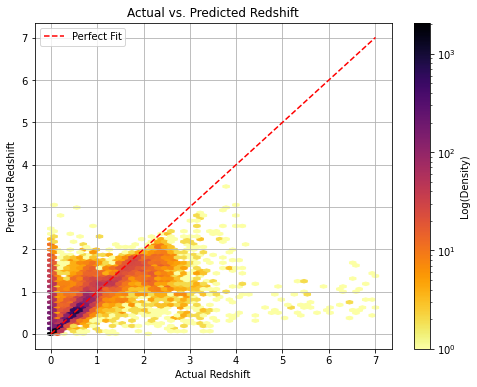

In [17]:
# 2D scatter plot on the entire test data
plt.figure(figsize=(8, 6))
hb = plt.hexbin(y3_test, y_pred_mean, gridsize=50, cmap='inferno_r', bins='log', mincnt=1)

# 1:1 Perfect Fit Line
plt.plot([min(y3_test), max(y3_test)], [min(y3_test), max(y3_test)], linestyle='--', color='red', label='Perfect Fit')

# Labels and title
plt.xlabel("Actual Redshift")
plt.ylabel("Predicted Redshift")
plt.title("Actual vs. Predicted Redshift")
plt.colorbar(label='Log(Density)')  # Color bar indicating density
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [6]:
# Define confidence threshold 
confidence_threshold1 = 0.7 

# Keep confident predictions
confident_predictions1 = y_pred_mean[y_pred_std < confidence_threshold1]
confident_actuals1 = y3_test[y_pred_std < confidence_threshold1]
print(f"Retained {len(confident_predictions1)} out of {len(y3_test)} predictions")

# Evaluate performance
mse = mean_squared_error(confident_actuals1, confident_predictions1)
mase_value = mase_seasonal(confident_actuals1, confident_predictions1)

print("MSE:", mse)
print(f"RMSE:", np.sqrt(mse))
print(f"MAE:", mean_absolute_error(confident_actuals1, confident_predictions1))
print("MASE (Seasonal):", mase_value)
print(f"R2:", r2_score(confident_actuals1, confident_predictions1))

Retained 15918 out of 20000 predictions
MSE: 0.10445572703274487
RMSE: 0.3231961123416321
MAE: 0.11558962584425092
MASE (Seasonal): 0.2256367896669529
R2: 0.6320124696810531


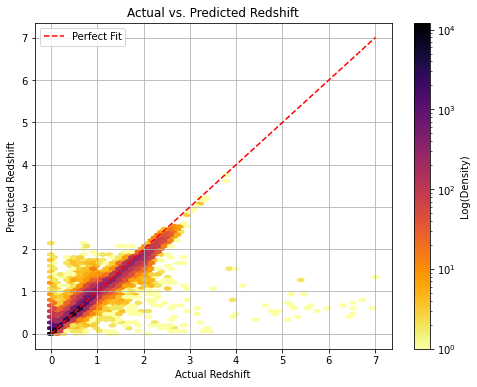

In [24]:
# 2D scatter plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(confident_actuals, confident_predictions, gridsize=50, cmap='inferno_r', bins='log', mincnt=1)

# 1:1 Perfect Fit Line
plt.plot([min(confident_actuals), max(confident_actuals)], [min(confident_actuals), max(confident_actuals)], linestyle='--', color='red', label='Perfect Fit')

# Labels and title
plt.xlabel("Actual Redshift")
plt.ylabel("Predicted Redshift")
plt.title("Actual vs. Predicted Redshift")
plt.colorbar(label='Log(Density)')  # Color bar indicating density
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

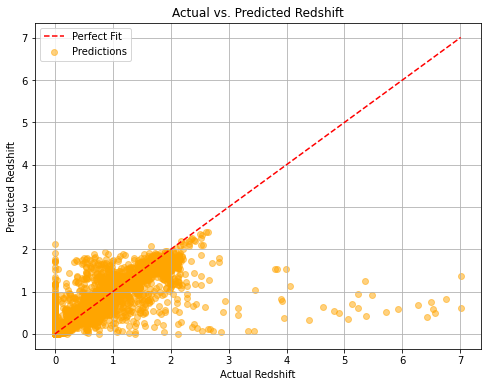

In [7]:
# Scatter plot of actual vs. predicted redshifts
plt.figure(figsize=(8, 6))
plt.scatter(confident_actuals1, confident_predictions1, alpha=0.5, color='orange', label='Predictions')
plt.plot([min(confident_actuals1), max(confident_actuals1)], [min(confident_actuals1), max(confident_actuals1)], linestyle='--', color='red', label='Perfect Fit')  # 1:1 line

# Labels and title
plt.xlabel("Actual Redshift")
plt.ylabel("Predicted Redshift")
plt.title("Actual vs. Predicted Redshift")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

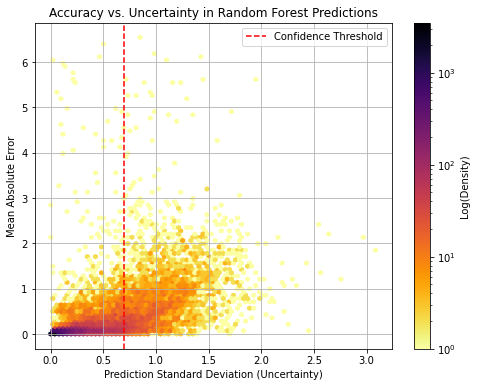

In [39]:
# Scatter plot of mean predictions vs. standard deviation
plt.figure(figsize=(8, 6))
mae_per_sample = np.abs(y3_test - y_pred_mean)

hb = plt.hexbin(y_pred_std, mae_per_sample, gridsize=80, cmap='inferno_r', bins='log', mincnt=1)

# Add threshold line
plt.axvline(confidence_threshold1, color="r", linestyle="--", label="Confidence Threshold")

# Labels and title
plt.xlabel("Prediction Standard Deviation (Uncertainty)")
plt.ylabel("Mean Absolute Error")
plt.title("Accuracy vs. Uncertainty in Random Forest Predictions")
plt.colorbar(label='Log(Density)')  # Color bar indicating density
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [18]:
# predictions on full dataset with confidence threshold
predictions_per_tree = np.stack([tree.predict(X3) for tree in rf3_model.estimators_])

# Compute mean prediction and standard deviation 
y_pred_mean = predictions_per_tree.mean(axis=0)
y_pred_std = predictions_per_tree.std(axis=0)

# Define confidence threshold 
confidence_threshold = 0.7 

# Keep confident predictions
confident_predictions = y_pred_mean[y_pred_std < confidence_threshold]
confident_actuals = y3[y_pred_std < confidence_threshold]
print(f"Retained {len(confident_predictions)} out of {len(y3)} predictions")

# Evaluate performance
mse = mean_squared_error(confident_actuals1, confident_predictions1)
mase_value = mase_seasonal(confident_actuals1, confident_predictions1)

print("MSE:", mse)
print(f"RMSE:", np.sqrt(mse))
print(f"MAE:", mean_absolute_error(confident_actuals1, confident_predictions1))
print("MASE (Seasonal):", mase_value)
print(f"R2:", r2_score(confident_actuals1, confident_predictions1))

/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWa

/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWa

Retained 86949 out of 99999 predictions
0.08308761915461473
0.28824923096968486
0.09684596222766947
0.6633413325139128


/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


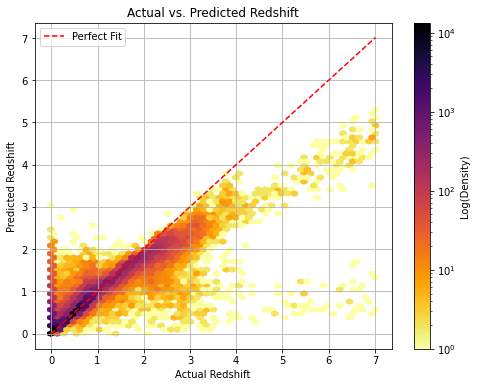

In [19]:
# 2D scatter plot on the entire test data
plt.figure(figsize=(8, 6))
hb = plt.hexbin(y3, y_pred_mean, gridsize=50, cmap='inferno_r', bins='log', mincnt=1)

# 1:1 Perfect Fit Line
plt.plot([min(y3), max(y3)], [min(y3), max(y3)], linestyle='--', color='red', label='Perfect Fit')

# Labels and title
plt.xlabel("Actual Redshift")
plt.ylabel("Predicted Redshift")
plt.title("Actual vs. Predicted Redshift")
plt.colorbar(label='Log(Density)')  # Color bar indicating density
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

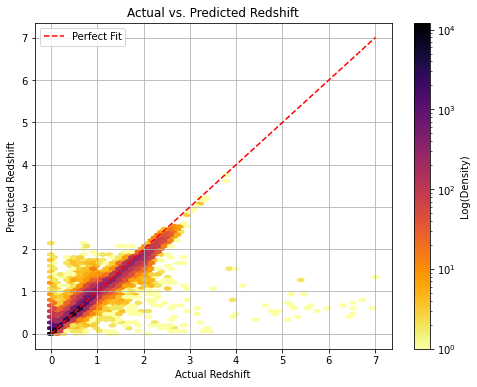

In [20]:
# 2D scatter plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(confident_actuals, confident_predictions, gridsize=50, cmap='inferno_r', bins='log', mincnt=1)

# 1:1 Perfect Fit Line
plt.plot([min(confident_actuals), max(confident_actuals)], [min(confident_actuals), max(confident_actuals)], linestyle='--', color='red', label='Perfect Fit')

# Labels and title
plt.xlabel("Actual Redshift")
plt.ylabel("Predicted Redshift")
plt.title("Actual vs. Predicted Redshift")
plt.colorbar(label='Log(Density)')  # Color bar indicating density
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

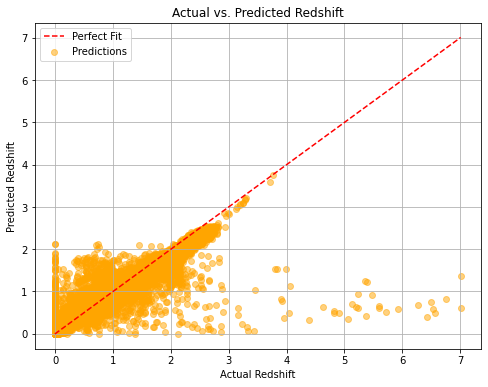

In [9]:
# Scatter plot of actual vs. predicted redshifts
plt.figure(figsize=(8, 6))
plt.scatter(confident_actuals, confident_predictions, alpha=0.5, color='orange', label='Predictions')
plt.plot([min(confident_actuals), max(confident_actuals)], [min(confident_actuals), max(confident_actuals)], linestyle='--', color='red', label='Perfect Fit')  # 1:1 line

# Labels and title
plt.xlabel("Actual Redshift")
plt.ylabel("Predicted Redshift")
plt.title("Actual vs. Predicted Redshift")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [10]:
# merge datasets: predicted redshifts of galaxies with full dataset
y_pred_mean_1 = y_pred_mean[:, None]
red_actual1 = red_actual[:, None]
X = np.array(X)
pred_df = np.concatenate((X, red_actual1, y_pred_mean_1), axis=1)
pred_df = pred_df[y_pred_std < confidence_threshold]
pred_df = pd.DataFrame(pred_df, columns=df.columns)
pred_df = pred_df.rename(columns={'redshift': 'redshift_pred'})


pred_df = pred_df.sample(frac=1, random_state = 42)
print(pred_df.describe())
print(pred_df.head(10))

                  u             g             r             i             z  \
count  86949.000000  86949.000000  86949.000000  86949.000000  86949.000000   
mean      21.988239     20.517205     19.456156     18.848612     18.514326   
std        2.318753      2.108372      1.873011      1.720699      1.705224   
min       12.996640     10.730970      9.822070      9.469903      9.612333   
25%       20.148330     18.680900     17.812190     17.418010     17.173570   
50%       22.071890     20.968880     19.867040     19.160740     18.776140   
75%       23.683900     22.160420     20.880000     20.044960     19.622160   
max       30.660390     31.602240     29.571860     32.141470     29.383740   

              Class  redshift_pred  
count  86949.000000   86949.000000  
mean       0.547148       0.487395  
std        0.802865       0.480668  
min        0.000000      -0.002016  
25%        0.000000       0.101828  
50%        0.000000       0.416324  
75%        1.000000       0.6

In [11]:
# raw data Random Forest
## train test split
X1 = pred_df.drop('Class',axis='columns')
y1 = np.array(pred_df['Class'])

rfc_model = RandomForestClassifier(
    max_depth=30,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

# Generate predictions using cross-validation
y_pred_c = cross_val_predict(rfc_model, X1, y1, cv=5)

print(f" classification accuracy: ", accuracy_score(y1, y_pred_c))
print(confusion_matrix(y_pred_c, y1))
print(classification_report(y_pred_c, y1))

0.956008694752096
[[55185  1264  1006]
 [  578 11750    56]
 [  863    58 16189]]
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97     57455
         1.0       0.90      0.95      0.92     12384
         2.0       0.94      0.95      0.94     17110

    accuracy                           0.96     86949
   macro avg       0.94      0.95      0.94     86949
weighted avg       0.96      0.96      0.96     86949

